In [1]:
# Code with the inclusion of temperature.
import numpy as np
import pandas as pd
from pyDOE import lhs  # Importing Latin Hypercube Sampling (LHS) function

# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples
num_samples = 100

# Define the ranges for LHS sampling
C_range = (0.3, 3)
N_range = (0.1, 4)
Y_n_range = (0.4, 4.88)
Y_h_range = (4.68, 188.2)
T_range = (20, 25)  # Temperature range

# Generate LHS samples within the defined ranges
lhs_samples = lhs(5, samples=num_samples)

# Scale the LHS samples to the desired ranges
C_values = lhs_samples[:, 0] * (C_range[1] - C_range[0]) + C_range[0]
N_values = lhs_samples[:, 1] * (N_range[1] - N_range[0]) + N_range[0]
Y_n_values = lhs_samples[:, 2] * (Y_n_range[1] - Y_n_range[0]) + Y_n_range[0]
Y_h_values = lhs_samples[:, 3] * (Y_h_range[1] - Y_h_range[0]) + Y_h_range[0]
T_values = lhs_samples[:, 4] * (T_range[1] - T_range[0]) + T_range[0]

# Create a DataFrame to store the generated values
generated_values_df = pd.DataFrame({
    'C_initial': C_values,
    'N_initial': N_values,
    'Y_n': Y_n_values,
    'Y_h': Y_h_values,
    'temperature': T_values
})

# Display the generated values
print(generated_values_df.head())

# Save the generated values to CSV
initial_conditions_csv_file = 'lhs_initial_conditions_with_temperature.csv'
generated_values_df.to_csv(initial_conditions_csv_file, index=False)
print(f"Initial conditions and temperature values have been saved to {initial_conditions_csv_file}")

   C_initial  N_initial       Y_n         Y_h  temperature
0   2.787173   1.838164  4.167286  122.646535    20.372008
1   1.448816   1.508425  1.075317  107.623676    21.916951
2   1.249708   3.649443  4.451005   42.317329    24.131592
3   0.826332   2.863403  4.280496  174.588998    20.109091
4   1.588506   2.572949  2.375397   70.631087    23.503528
Initial conditions and temperature values have been saved to lhs_initial_conditions_with_temperature.csv


In [3]:
# Function to calculate K(T)
def K(T):
    return 3 * 10**4 * np.exp(-6050 / (T + 273))

# Constants and parameters for the simulation
dt = 60  # Time step in seconds
t_max = 12 * 60 * 60  # Total time in sec

# Function for RK4 method
def rk4(f, t, y0, args=()):
    h = t[1] - t[0]
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(len(t) - 1):
        k1 = h * np.array(f(t[i], y[i], *args))
        k2 = h * np.array(f(t[i] + 0.5 * h, y[i] + 0.5 * k1, *args))
        k3 = h * np.array(f(t[i] + 0.5 * h, y[i] + 0.5 * k2, *args))
        k4 = h * np.array(f(t[i] + h, y[i] + k3, *args))
        y[i + 1] = y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return y

# Function for differential equations
def model(t, y, T, Y_n, Y_h):
    C, N, H = y
    k = K(T)
    dCdt = -k * C * N
    dNdt = -Y_n * k * C * N
    dHdt = Y_h * k * C * N  # Note the positive sign for dHdt
    return [dCdt, dNdt, dHdt]

# Time points
time_points = np.arange(0, t_max + dt, dt)

# Initial value for H
H0 = 0

# Prepare to store results
results = []

# Perform simulations for each set of initial conditions and temperature
for i in range(num_samples):
    C_init = C_values[i]
    N_init = N_values[i]
    Y_n_value = Y_n_values[i]
    Y_h_value = Y_h_values[i]
    T = T_values[i]

    initial_conditions = [C_init, N_init, H0]

    # Integrate the system using RK4
    sol = rk4(model, time_points, initial_conditions, args=(T, Y_n_value, Y_h_value))

    # Store results
    for j, t in enumerate(time_points):
        results.append({
            'simulation_id': i + 1,  # Unique identifier for each simulation
            'temperature': T,
            'time': t,
            'C': sol[j, 0],
            'N': sol[j, 1],
            'H': sol[j, 2],
            'C_initial': C_init,
            'N_initial': N_init,
            'Y_n': Y_n_value,
            'Y_h': Y_h_value
        })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Save results to CSV
results_csv_file = 'lhstest_simulated_results_with_temperatures.csv'
results_df.to_csv(results_csv_file, index=False)

# Display confirmation message
print(f"Simulation results have been saved to {results_csv_file}")

# Display the first few rows of the results
results_df.head(10)


Simulation results have been saved to lhstest_simulated_results_with_temperatures.csv


,simulation_id,temperature,time,C,N,H,C_initial,N_initial,Y_n,Y_h
0,1,20.372008,0,2.787173,1.838164,0.000000,2.787173,1.838164,4.167286,122.646535
1,1,20.372008,60,2.777107,1.796213,1.234642,2.787173,1.838164,4.167286,122.646535
2,1,20.372008,120,2.767304,1.755365,2.436849,2.787173,1.838164,4.167286,122.646535
3,1,20.372008,180,2.757758,1.715583,3.607663,2.787173,1.838164,4.167286,122.646535
4,1,20.372008,240,2.748460,1.676834,4.748084,2.787173,1.838164,4.167286,122.646535
5,1,20.372008,300,2.739401,1.639084,5.859073,2.787173,1.838164,4.167286,122.646535
6,1,20.372008,360,2.730575,1.602304,6.941553,2.787173,1.838164,4.167286,122.646535
7,1,20.372008,420,2.721974,1.566462,7.996409,2.787173,1.838164,4.167286,122.646535
8,1,20.372008,480,2.713592,1.531530,9.024493,2.787173,1.838164,4.167286,122.646535
9,1,20.372008,540,2.705421,1.497479,10.026625,2.787173,1.838164,4.167286,122.646535


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'lhstest_simulated_results_with_temperatures.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

   simulation_id  temperature  time         C         N         H  C_initial  \
0              1    20.372008     0  2.787173  1.838164  0.000000   2.787173   
1              1    20.372008    60  2.777022  1.826629  1.245013   2.787173   
2              1    20.372008   120  2.766971  1.815207  2.477735   2.787173   
3              1    20.372008   180  2.757019  1.803898  3.698343   2.787173   
4              1    20.372008   240  2.747164  1.792699  4.907011   2.787173   

   N_initial       Y_n         Y_h  
0   1.838164  1.136365  122.646535  
1   1.838164  1.136365  122.646535  
2   1.838164  1.136365  122.646535  
3   1.838164  1.136365  122.646535  
4   1.838164  1.136365  122.646535  


In [22]:
from sklearn.model_selection import train_test_split

# Extract unique simulation IDs
simulation_ids = df['simulation_id'].unique()

# Split simulation IDs into train, validation, and test sets
train_ids, temp_ids = train_test_split(simulation_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Split the data based on simulation IDs
train_data = df[df['simulation_id'].isin(train_ids)]
val_data = df[df['simulation_id'].isin(val_ids)]
test_data = df[df['simulation_id'].isin(test_ids)]

# Display the split information
print("Training Simulation IDs:", train_ids)
print("Validation Simulation IDs:", val_ids)
print("Test Simulation IDs:", test_ids)

Training Simulation IDs: [ 12  48  86  29  94   6  67  66  36  17  50  35   8  96  28  20  82  26
  63  14  25   4  18  39   9  79   7  65  37  90  57 100  55  44  51  68
  47  69  62  98  80  42  59  49  99  58  76  33  95  60  64  85  38  30
   2  53  22   3  24  88  92  75  87  83  21  61  72  15  93  52]
Validation Simulation IDs: [27 54 71 16 46 89 41 13 73 56 81 19 91 32 23]
Test Simulation IDs: [97  5 43 78 11  1 10 70 74 84 45 77 40 34 31]


In [23]:
# Define features and targets
features = ['temperature' , 'time', 'C_initial', 'N_initial', 'Y_n', 'Y_h']
targets = ['C', 'N', 'H']

# Extract features and targets for each split
X_train = train_data[features]
y_train = train_data[targets]

X_val = val_data[features]
y_val = val_data[targets]

X_test = test_data[features]
y_test = test_data[targets]

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the features and targets for training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Transform the validation and test data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("Training Data:")
print(train_data)

print("Training Data:")
print(train_data)

print("Test Data:")
print(test_data)

Training Data:
       simulation_id  temperature   time         C         N          H  \
721                2    21.916951      0  1.448816  1.508425   0.000000   
722                2    21.916951     60  1.443982  1.504267   0.520196   
723                2    21.916951    120  1.439178  1.500134   1.037232   
724                2    21.916951    180  1.434403  1.496026   1.551136   
725                2    21.916951    240  1.429657  1.491943   2.061938   
...              ...          ...    ...       ...       ...        ...   
72095            100    24.726385  42960  0.659665  0.214864  45.302345   
72096            100    24.726385  43020  0.659284  0.214473  45.315364   
72097            100    24.726385  43080  0.658904  0.214083  45.328353   
72098            100    24.726385  43140  0.658524  0.213694  45.341310   
72099            100    24.726385  43200  0.658146  0.213306  45.354236   

       C_initial  N_initial       Y_n         Y_h  
721     1.448816   1.508425  0.8

In [25]:
# Define the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(32, activation='relu'),
    Dense(3)  # Output layer for C, N, H
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val_scaled))

# Save the trained model
model.save('test_combined_model.h5')

Epoch 1/50


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1578/1578 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0151 - mae: 0.0683 - mse: 0.0151 - val_loss: 2.9254e-04 - val_mae: 0.0124 - val_mse: 2.9254e-04
Epoch 2/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.5606e-04 - mae: 0.0091 - mse: 1.5606e-04 - val_loss: 2.5770e-04 - val_mae: 0.0120 - val_mse: 2.5770e-04
Epoch 3/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 7.7485e-05 - mae: 0.0065 - mse: 7.7485e-05 - val_loss: 1.6866e-04 - val_mae: 0.0096 - val_mse: 1.6866e-04
Epoch 4/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 5.3108e-05 - mae: 0.0054 - mse: 5.3108e-05 - val_loss: 1.9132e-04 - val_mae: 0.0106 - val_mse: 1.9132e-04
Epoch 5/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 4.2930e-05 - mae: 0.0049 - mse: 4.2930e-05 - val_loss: 2.0297e-04 - val_mae: 0.0106 - val_mse: 2.0297e-04
Epoch 6/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.5617e-05 - mae: 0.0045 - mse: 3.5617e-05 - val_loss: 1.5272e-04 - val_mae: 0.0094 - val_mse: 1.5272e-04
Epoch 7/5

In [26]:
# Evaluate the model on the test set
loss, mae, mse = model.evaluate(X_test_reshaped, y_test_scaled)
print(f'Test Loss: {loss}, Test MAE: {mae}, Test MSE: {mse}')

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4049e-04 - mae: 0.0110 - mse: 2.4049e-04
Test Loss: 0.0001874513691291213, Test MAE: 0.009975221008062363, Test MSE: 0.0001874513691291213


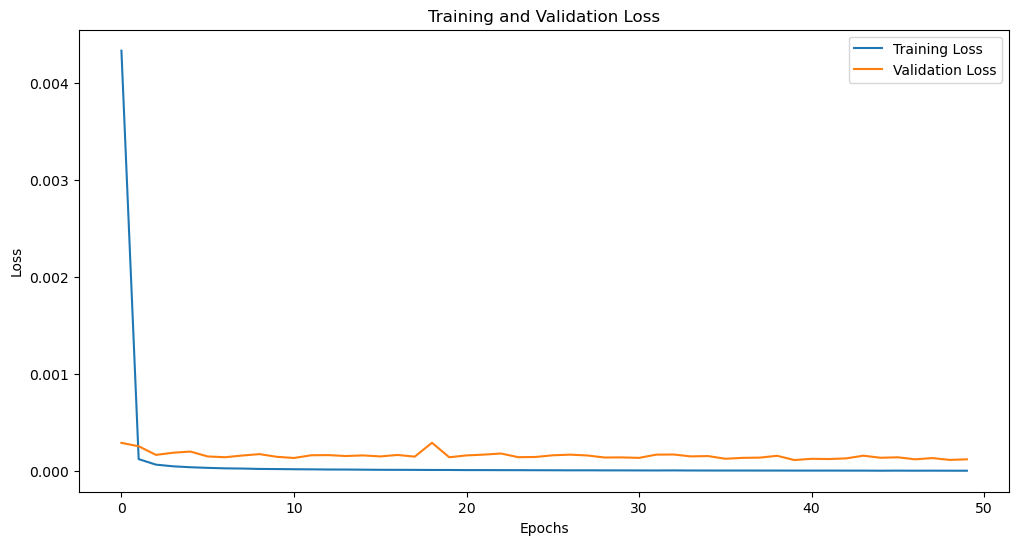

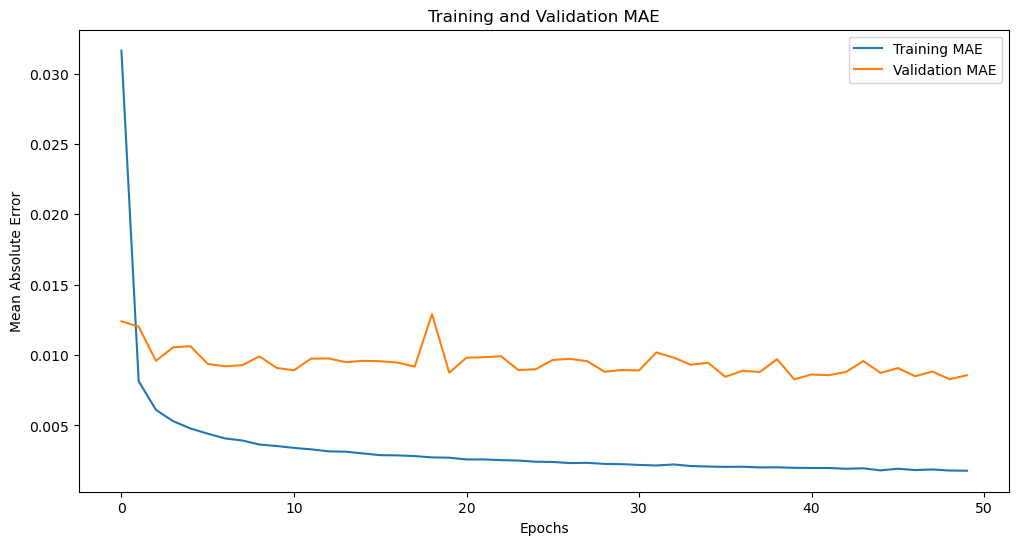

In [27]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


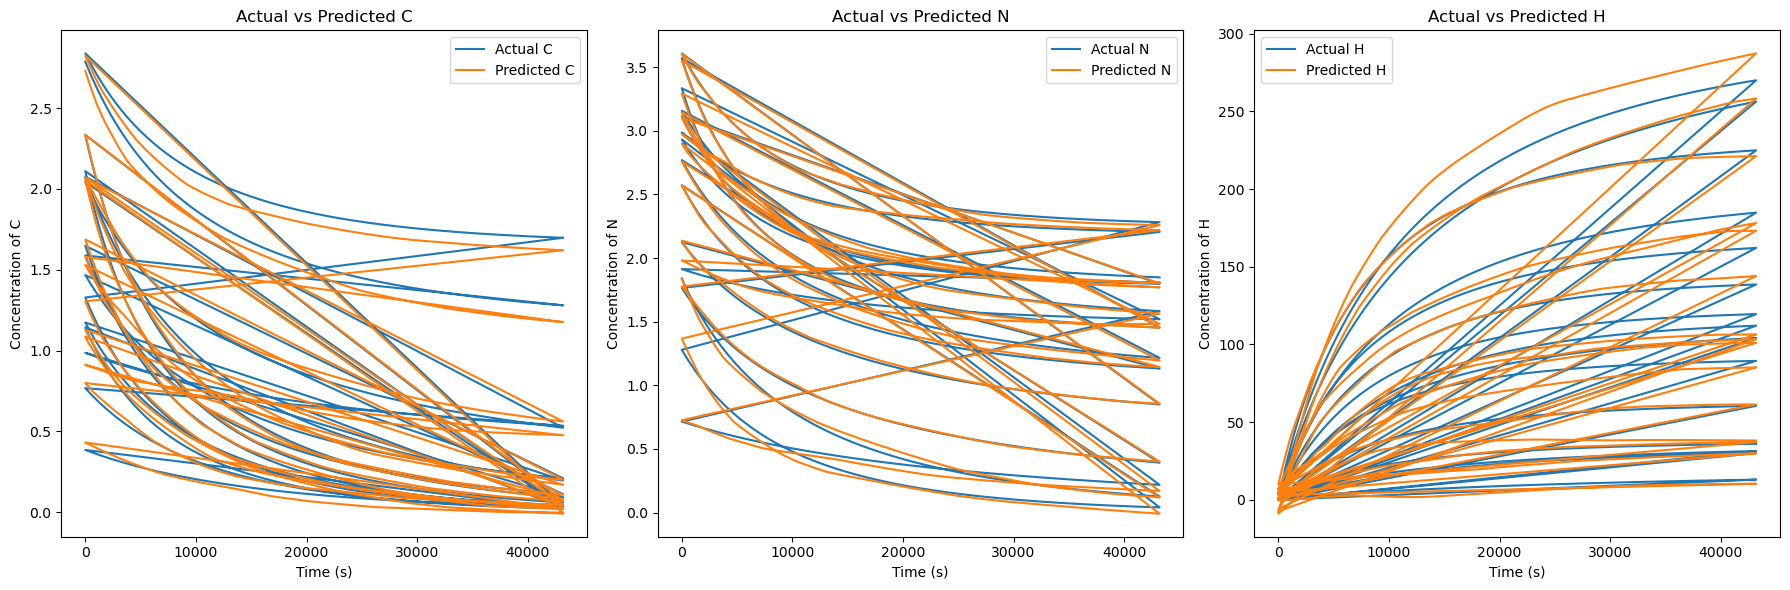

In [28]:
# Predict on the test set
y_test_pred_scaled = model.predict(X_test_reshaped)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Extract actual values from the test set
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Plot actual vs. predicted values for C, N, and H
time_steps = test_data['time'].values

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(time_steps, y_test_actual[:, 0], label='Actual C')
plt.plot(time_steps, y_test_pred[:, 0], label='Predicted C')
plt.xlabel('Time (s)')
plt.ylabel('Concentration of C')
plt.title('Actual vs Predicted C')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(time_steps, y_test_actual[:, 1], label='Actual N')
plt.plot(time_steps, y_test_pred[:, 1], label='Predicted N')
plt.xlabel('Time (s)')
plt.ylabel('Concentration of N')
plt.title('Actual vs Predicted N')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(time_steps, y_test_actual[:, 2], label='Actual H')
plt.plot(time_steps, y_test_pred[:, 2], label='Predicted H')
plt.xlabel('Time (s)')
plt.ylabel('Concentration of H')
plt.title('Actual vs Predicted H')
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
# Example input values for prediction
temperature = 21.9169514895524
time = 35100 # Time in sec
C_initial = 1.44881581231289
N_initial = 1.50842546732838
Y_n = 0.860296178606936
Y_h = 107.623675655995

# Create a DataFrame for the input
input_data = pd.DataFrame({
    'temperature': [temperature],
    'time': [time],
    'C_initial': [C_initial],
    'N_initial': [N_initial],
    'Y_n': [Y_n],
    'Y_h': [Y_h]
})

# Normalize the input data
input_data_scaled = scaler_X.transform(input_data)

# Reshape the input data for the LSTM model
input_data_reshaped = input_data_scaled.reshape((input_data_scaled.shape[0], 1, input_data_scaled.shape[1]))

# Make the prediction
predicted_scaled = model.predict(input_data_reshaped)

# Inverse transform the predicted values to get the actual concentrations
predicted = scaler_y.inverse_transform(predicted_scaled)

# Extract the predicted concentrations for C, N, and H
predicted_C = predicted[0, 0]
predicted_N = predicted[0, 1]
predicted_H = predicted[0, 2]

print(f'Predicted C: {predicted_C}')
print(f'Predicted N: {predicted_N}')
print(f'Predicted H: {predicted_H}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted C: 0.43232253193855286
Predicted N: 0.6351512670516968
Predicted H: 108.33277130126953


In [31]:
# Example input values for prediction
temperature = 20.37
time = 35100 # Time in sec
C_initial = 2.78717320866298
N_initial = 1.83816403553008
Y_n = 1.13636482441219
Y_h = 122.646534687675

# Create a DataFrame for the input
input_data = pd.DataFrame({
    'temperature': [temperature],
    'time': [time],
    'C_initial': [C_initial],
    'N_initial': [N_initial],
    'Y_n': [Y_n],
    'Y_h': [Y_h]
})

# Normalize the input data
input_data_scaled = scaler_X.transform(input_data)

# Reshape the input data for the LSTM model
input_data_reshaped = input_data_scaled.reshape((input_data_scaled.shape[0], 1, input_data_scaled.shape[1]))

# Make the prediction
predicted_scaled = model.predict(input_data_reshaped)

# Inverse transform the predicted values to get the actual concentrations
predicted = scaler_y.inverse_transform(predicted_scaled)

# Extract the predicted concentrations for C, N, and H
predicted_C = predicted[0, 0]
predicted_N = predicted[0, 1]
predicted_H = predicted[0, 2]

print(f'Predicted C: {predicted_C}')
print(f'Predicted N: {predicted_N}')
print(f'Predicted H: {predicted_H}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted C: 1.2378510236740112
Predicted N: 0.18446916341781616
Predicted H: 165.41517639160156


   simulation_id  temperature  time         C         N         H  C_initial  \
0              1    20.372008     0  2.787173  1.838164  0.000000   2.787173   
1              1    20.372008    60  2.777022  1.826629  1.245013   2.787173   
2              1    20.372008   120  2.766971  1.815207  2.477735   2.787173   
3              1    20.372008   180  2.757019  1.803898  3.698343   2.787173   
4              1    20.372008   240  2.747164  1.792699  4.907011   2.787173   

   N_initial       Y_n         Y_h  
0   1.838164  1.136365  122.646535  
1   1.838164  1.136365  122.646535  
2   1.838164  1.136365  122.646535  
3   1.838164  1.136365  122.646535  
4   1.838164  1.136365  122.646535  
Training Data:
       simulation_id  temperature   time         C         N          H  \
721                2    21.916951      0  1.448816  1.508425   0.000000   
722                2    21.916951     60  1.443982  1.504267   0.520196   
723                2    21.916951    120  1.439178  1.500

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1578/1578 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0148 - mae: 0.0668 - mse: 0.0148 - val_loss: 2.9850e-04 - val_mae: 0.0135 - val_mse: 2.9850e-04
Epoch 2/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.4823e-04 - mae: 0.0090 - mse: 1.4823e-04 - val_loss: 1.6961e-04 - val_mae: 0.0101 - val_mse: 1.6961e-04
Epoch 3/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 7.8216e-05 - mae: 0.0067 - mse: 7.8216e-05 - val_loss: 1.5729e-04 - val_mae: 0.0099 - val_mse: 1.5729e-04
Epoch 4/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 5.1395e-05 - mae: 0.0055 - mse: 5.1395e-05 - val_loss: 2.1775e-04 - val_mae: 0.0112 - val_mse: 2.1775e-04
Epoch 5/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 4.0050e-05 - mae: 0.0048 - mse: 4.0050e-05 - val_loss: 2.3562e-04 - val_mae: 0.0115 - val_mse: 2.3562e-04
Epoch 6/50
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 3.3649e-05 - mae: 0.0044 - mse: 3.3649e-05 - val_loss: 1.7634e-04 - val_mae: 0.0098 - val_mse: 1.7634e-04
Epoch 7/50

338/338 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0296e-05 - mae: 0.0071 - mse: 9.0296e-05
Test Loss: 0.00010178615775657818, Test MAE: 0.006909728050231934, Test MSE: 0.00010178615775657818


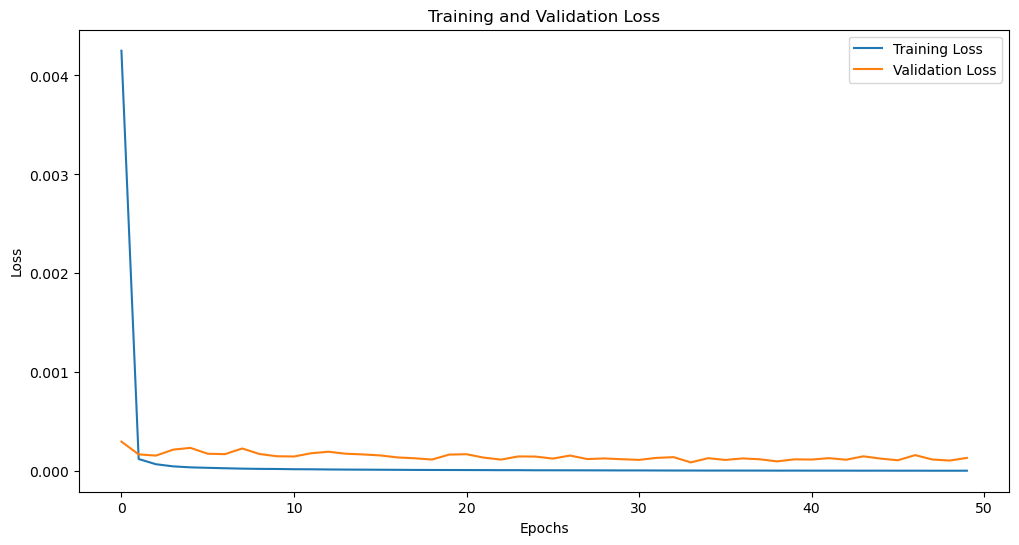

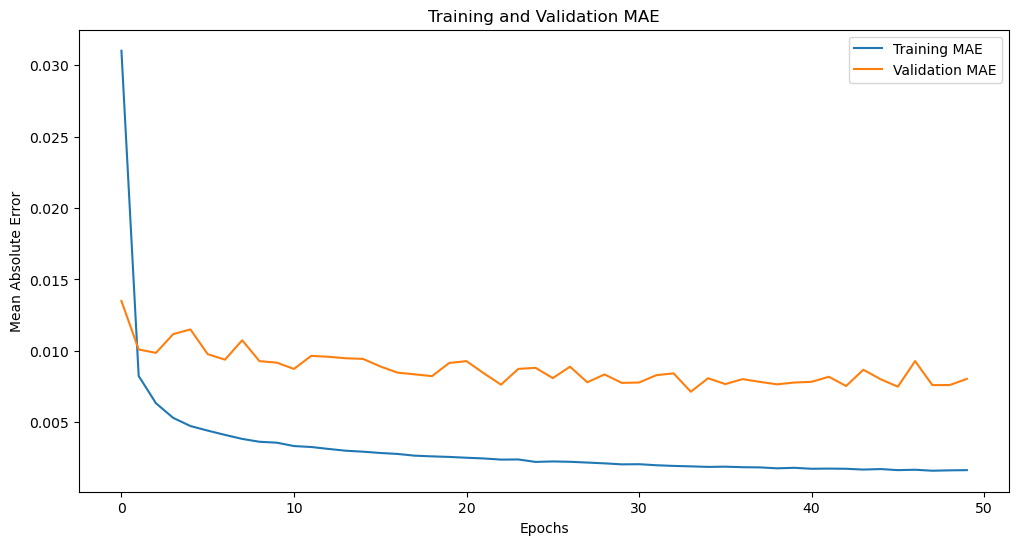

338/338 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


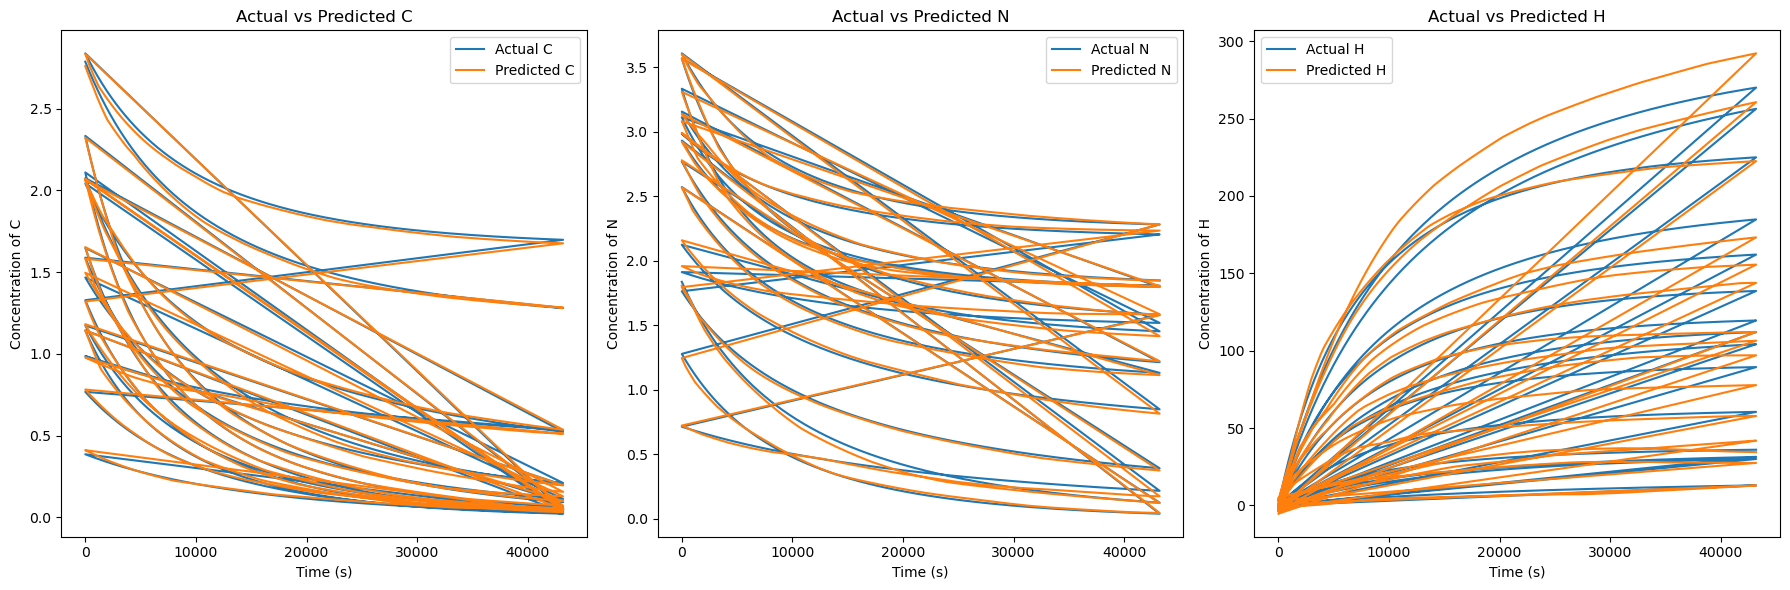

In [36]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'lhstest_simulated_results_with_temperatures.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

# Extract unique simulation IDs
simulation_ids = df['simulation_id'].unique()

# Split simulation IDs into train, validation, and test sets
train_ids, temp_ids = train_test_split(simulation_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Split the data based on simulation IDs
train_data = df[df['simulation_id'].isin(train_ids)]
val_data = df[df['simulation_id'].isin(val_ids)]
test_data = df[df['simulation_id'].isin(test_ids)]

# Define features and targets
features = ['temperature' , 'time', 'C_initial', 'N_initial', 'Y_n', 'Y_h']
targets = ['C', 'N', 'H']

# Extract features and targets for each split
X_train = train_data[features]
y_train = train_data[targets]

X_val = val_data[features]
y_val = val_data[targets]

X_test = test_data[features]
y_test = test_data[targets]

# Initialize the scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the features and targets for training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Transform the validation and test data
X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val)

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_reshaped = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("Training Data:")
print(train_data)

print("Test Data:")
print(test_data)

# Define the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(32, activation='relu'),
    Dense(3)  # Output layer for C, N, H
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

# Train the model
history = model.fit(X_train_reshaped, y_train_scaled, epochs=50, batch_size=32, validation_data=(X_val_reshaped, y_val_scaled))

# Save the trained model
model.save('test_combined_model.h5')

# Evaluate the model on the test set
loss, mae, mse = model.evaluate(X_test_reshaped, y_test_scaled)
print(f'Test Loss: {loss}, Test MAE: {mae}, Test MSE: {mse}')

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

# Predict on the test set
y_test_pred_scaled = model.predict(X_test_reshaped)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

# Extract actual values from the test set
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Plot actual vs. predicted values for C, N, and H
time_steps = test_data['time'].values

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(time_steps, y_test_actual[:, 0], label='Actual C')
plt.plot(time_steps, y_test_pred[:, 0], label='Predicted C')
plt.xlabel('Time (s)')
plt.ylabel('Concentration of C')
plt.title('Actual vs Predicted C')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(time_steps, y_test_actual[:, 1], label='Actual N')
plt.plot(time_steps, y_test_pred[:, 1], label='Predicted N')
plt.xlabel('Time (s)')
plt.ylabel('Concentration of N')
plt.title('Actual vs Predicted N')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(time_steps, y_test_actual[:, 2], label='Actual H')
plt.plot(time_steps, y_test_pred[:, 2], label='Predicted H')
plt.xlabel('Time (s)')
plt.ylabel('Concentration of H')
plt.title('Actual vs Predicted H')
plt.legend()

plt.tight_layout()
plt.show()



In [38]:
# Load the new input CSV file
input_file_path = 'lhstest_simulated_results_with_temperatures.csv'
new_input_df = pd.read_csv(input_file_path)

# Normalize the input data
new_input_scaled = scaler_X.transform(new_input_df[features])

# Reshape the input data for the LSTM model
new_input_reshaped = new_input_scaled.reshape((new_input_scaled.shape[0], 1, new_input_scaled.shape[1]))

# Make predictions
new_predictions_scaled = model.predict(new_input_reshaped)
new_predictions = scaler_y.inverse_transform(new_predictions_scaled)

# Calculate errors (e.g., Mean Absolute Error) for each prediction
errors = np.abs(new_predictions - new_input_df[targets].values)

# Calculate percentage errors
percentage_errors = (errors / new_input_df[targets].values) * 100

# Save the predicted values, absolute errors, and percentage errors to a new CSV file
output_df = pd.DataFrame(new_predictions, columns=['Predicted_C', 'Predicted_N', 'Predicted_H'])
error_df = pd.DataFrame(errors, columns=['Error_C', 'Error_N', 'Error_H'])
percentage_error_df = pd.DataFrame(percentage_errors, columns=['Percentage_Error_C', 'Percentage_Error_N', 'Percentage_Error_H'])

result_df = pd.concat([new_input_df, output_df, error_df, percentage_error_df], axis=1)
result_df.to_csv('predictions_with_errors.csv', index=False)

print(result_df.head())


2254/2254 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


C:\Users\HP\AppData\Local\Temp\ipykernel_9644\1774678002.py:19: RuntimeWarning: divide by zero encountered in divide
  percentage_errors = (errors / new_input_df[targets].values) * 100


   simulation_id  temperature  time         C         N         H  C_initial  \
0              1    20.372008     0  2.787173  1.838164  0.000000   2.787173   
1              1    20.372008    60  2.777022  1.826629  1.245013   2.787173   
2              1    20.372008   120  2.766971  1.815207  2.477735   2.787173   
3              1    20.372008   180  2.757019  1.803898  3.698343   2.787173   
4              1    20.372008   240  2.747164  1.792699  4.907011   2.787173   

   N_initial       Y_n         Y_h  Predicted_C  Predicted_N  Predicted_H  \
0   1.838164  1.136365  122.646535     2.759748     1.808045     3.317389   
1   1.838164  1.136365  122.646535     2.748509     1.798766     4.402829   
2   1.838164  1.136365  122.646535     2.737381     1.789566     5.478444   
3   1.838164  1.136365  122.646535     2.726364     1.780446     6.544304   
4   1.838164  1.136365  122.646535     2.715456     1.771405     7.600425   

    Error_C   Error_N   Error_H  Percentage_Error_C  Per